## Project: Classifying Wine Using Logistic Regression model and SVM Model.
This project aims to deploy machine learning, specifically logistic regression model and SVM model, to classify wine type based on its chemical constituents. Using the 'wine' dataset from OpenML, which contains 13 chemical features of wines from Italy, we seek to develop a classification system to predict wine type (b'1', b'2', b'3') accurately.

### I. Data Loading and Understanding

In [288]:
#import libraries
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

#ignore warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

In [289]:
#load the ARFF file
data, meta = arff.loadarff('dataset_191_wine.arff')

#convert to a Pandas DataFrame
df = pd.DataFrame(data)

#display the first few rows 
df.head(2)

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,b'1',14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,b'1',13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


In [290]:
#get the diensions
df.shape

(178, 14)

In [291]:
#display DataFrame information, including column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   class                           178 non-null    object 
 1   Alcohol                         178 non-null    float64
 2   Malic_acid                      178 non-null    float64
 3   Ash                             178 non-null    float64
 4   Alcalinity_of_ash               178 non-null    float64
 5   Magnesium                       178 non-null    float64
 6   Total_phenols                   178 non-null    float64
 7   Flavanoids                      178 non-null    float64
 8   Nonflavanoid_phenols            178 non-null    float64
 9   Proanthocyanins                 178 non-null    float64
 10  Color_intensity                 178 non-null    float64
 11  Hue                             178 non-null    float64
 12  OD280%2FOD315_of_diluted_wines  178 

In [292]:
#get the unique values in the 'class' column, which illustrate the different wine types
#df['class'].unique()
# Create a mapping dictionary
class_mapping = {'1': 1, '2': 2, '3': 3}

# Map the values in the 'class' column using the mapping dictionary
df['class'] = df['class'].apply(lambda x: class_mapping[x.decode('utf-8')])

# Check the updated 'class' column
print(df['class'].unique())



[1 2 3]


### II. Data Preprocessing
Data preprocessing is a vital step that ensures the accuracy, completeness, and relevance of data for analysis or machine learning models. These tasks involve several key processes: 
#### 1. Data Cleaning
Data cleaning involves addressing issues like missing data, duplicates, and outliers, which can impact analysis or model training.
##### 1) Handling missing data

In [293]:
#find missing data
df.isna().sum()

class                             0
Alcohol                           0
Malic_acid                        0
Ash                               0
Alcalinity_of_ash                 0
Magnesium                         0
Total_phenols                     0
Flavanoids                        0
Nonflavanoid_phenols              0
Proanthocyanins                   0
Color_intensity                   0
Hue                               0
OD280%2FOD315_of_diluted_wines    0
Proline                           0
dtype: int64

**<span style="color:blue;">Observations:</span>**

The DataFrame df does not have any missing data

##### 2) Handling duplicated data

In [294]:
#find duplicated data
df.duplicated().sum()

0

**<span style="color:blue;">Observations:</span>**

The DataFrame df does not have any duplicated data

##### 3) Handling outliers

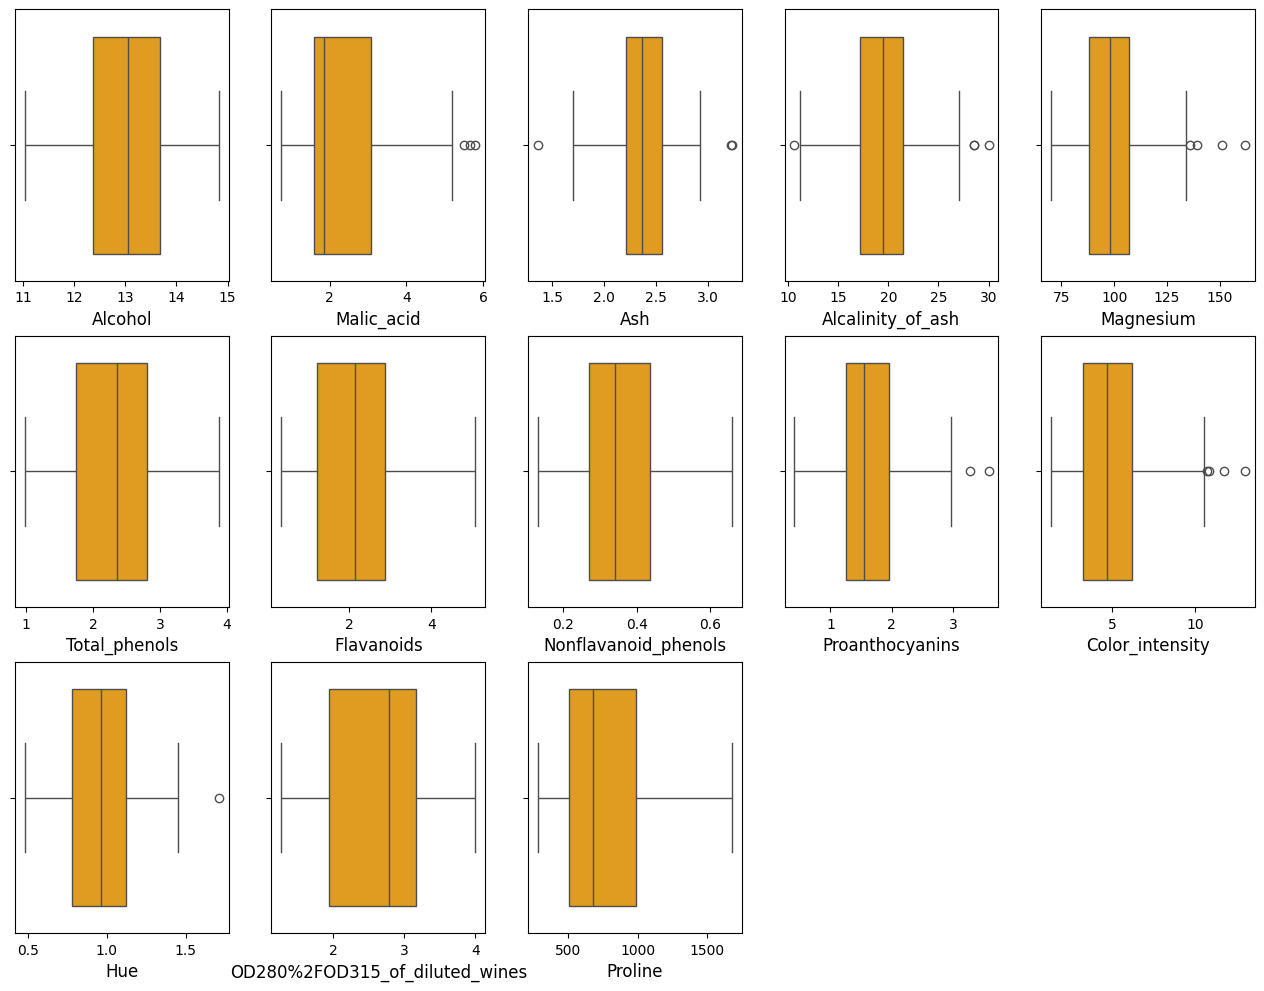

In [295]:
#find the outliers using boxplot
plt.figure(figsize = (16, 12))
for i, col in enumerate(df.iloc[:, 1:14]):
    plt.subplot(3, 5, i+1)
    sns.boxplot(data = df.iloc[:, 1:14], x = col , color = "orange")
    plt.xlabel(col, fontsize = 12)
    plt.xticks(fontsize = 10)

**<span style="color:blue;">Observations:</span>**

The boxplot displays some unusual data points, marked by the small circles, in 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Proanthocyanins', and 'Color_intensity'. These points are positioned more than 1.5 times the interquartile range (IQR) away from the quartiles, indicating they might be outliers.

In [296]:
#function to remove outliers 
#reference: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
def removeOutliers(df):
    
    for col in df.iloc[:, 1:14].columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

#remove outliers using function removeOutliers
df = removeOutliers(df)

#check the updated df
df.shape

(161, 14)

#### 2. Handling class imbalances
Class imbalances occur when the distribution of values for the class is not uniform, potentially leading to biased model performance. Techniques such as oversampling, undersampling, or adjusting class weights are commonly used to address this imbalance. For this project, the 'oversampling' technique will be employed due to the small dataset size (only 161 rows).

In [297]:
#check if there is class imbalance issue 
df['class'].value_counts()

class
2    61
1    57
3    43
Name: count, dtype: int64

In [298]:
#handling the class imbalance issue
#reference: https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/
#create an oversampler using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

#create features (X_imbalance) and target variable (y_imbalance)
X_imbalance = df.drop(columns=['class'])
y_imbalance = df['class']

#oversample the minority class
X_over, y_over = oversample.fit_resample(X_imbalance, y_imbalance)
print("Oversampled class distribution 1:", Counter(y_over))

#oversample the minority class
X_over2, y_over2 = oversample.fit_resample(X_over, y_over)
print("Oversampled class distribution 2:", Counter(y_over2))



Oversampled class distribution 1: Counter({2: 61, 3: 61, 1: 57})
Oversampled class distribution 2: Counter({1: 61, 2: 61, 3: 61})


#### 3. Feature Selection
Feature selection is essential for reducing model complexity, overfitting, and training time. 

When deciding on a feature selection method, we need to consider various factors, including dataset characteristics, computational cost, and modeling objectives.

**Correlation Matrix with Heatmap:** Inappropriate for our categorical target variable.

**RFE (Recursive Feature Elimination):** Not ideal for our two selected machine learning algorithms.

**SelectKBest:** Efficient and straightforward, suitable for quick feature selection.

**ExtraTreesClassifier:** Offers insights into feature importance and handles non-linear relationships well, aligning with our goal of creating logistic regression and SVC classifiers for wine type classification.

Considering our categorical target variable and the requirements of our logistic regression and SVC models, we've chosen ExtraTreesClassifier for feature selection.

In [299]:
#use ExtraTreesClassifier for feature selection
model = ExtraTreesClassifier()
model.fit(X_over2,y_over2)
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_indices = indices[:8]
selected_features = X_over2.columns[top_indices]
selected_features

Index(['Flavanoids', 'Proline', 'OD280%2FOD315_of_diluted_wines',
       'Color_intensity', 'Alcohol', 'Hue', 'Total_phenols', 'Malic_acid'],
      dtype='object')

In [300]:
#get features after Feature Selection
X = X_over2[selected_features]
y = y_over2

#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train= np.asarray(X_train)
y_train= np.asarray(y_train)
X_test= np.asarray(X_test)
y_test= np.asarray(y_test)
#print the size of training and test datasets
print(f'training set size: {X_train.shape[0]} samples \ntest set size: {X_test.shape[0]} samples')

training set size: 128 samples 
test set size: 55 samples


#### 4. Data Normalization:
Before building the model, it's essential to normalize the data since the unit of measurement might differ across features. This process ensures that all features contribute equally to the model. Here are the two steps involved:

- Step1: Visualize the distribution of each numerical column using a histogram to assess its normality. Look for a bell curve shape, which indicates a Gaussian distribution.

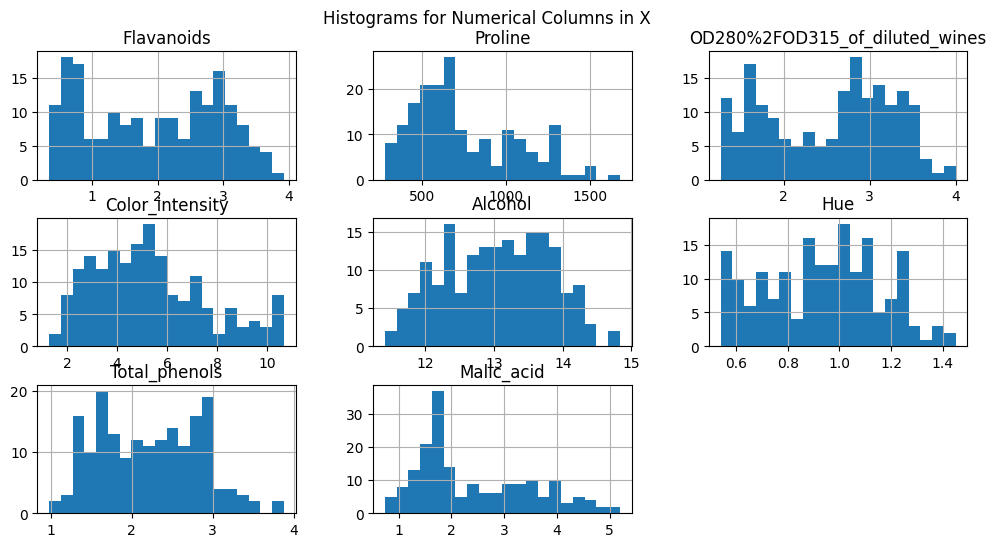

In [301]:
#visualize the distribution of each numerical column in X
numeric_columns = X.select_dtypes(include=['float64', 'int64'])

numeric_columns.hist(bins=20, figsize=(12, 6))
plt.suptitle('Histograms for Numerical Columns in X', y=0.95)
plt.show()

- Step2 Normalize the features based on the observed distribution. Since all columes exhibit non-Gaussian distributions, Min-Max Normalization will be applied to these columns

In [302]:
#Normalize the dataset

scaler= MinMaxScaler().fit(X_train) # the scaler is fitted to the training set
normalized_X_train= scaler.transform(X_train) # the scaler is applied to the training set
normalized_X_test= scaler.transform(X_test) # the scaler is applied to the test set
print('X train before Normalization')
print(X_train[0:3])
print('\nX train after Normalization')
print(normalized_X_train[0:3])

X train before Normalization
[[6.000e-01 5.900e+02 2.150e+00 4.920e+00 1.284e+01 8.900e-01 2.320e+00
  2.960e+00]
 [4.900e-01 5.100e+02 1.830e+00 5.500e+00 1.220e+01 6.600e-01 1.250e+00
  3.030e+00]
 [1.250e+00 4.500e+02 2.650e+00 3.600e+00 1.200e+01 1.050e+00 1.450e+00
  1.510e+00]]

X train after Normalization
[[0.03757225 0.22253923 0.31734317 0.38723404 0.41812865 0.38461538
  0.40684411 0.4988764 ]
 [0.00578035 0.16547789 0.19926199 0.44893617 0.23099415 0.13186813
  0.         0.51460674]
 [0.22543353 0.12268188 0.50184502 0.24680851 0.17251462 0.56043956
  0.07604563 0.17303371]]


### III. Model Building

#### 1. Logistic Regression Model Building

##### 1) Find the best hyperparameters using GridSearchCV

In [303]:
#build logistic regression model using default values
lr = LogisticRegression()

#define the hyperparameters to search for best lr
param_dict_lr = {'max_iter' : [50, 100, 1000],
              'penalty' : ['l1', 'l2'],
              'C' : [1, 10, 100],
              'solver' : ['liblinear','lbfgs', 'saga']}

#perform GridSearchCV
grid_lr = GridSearchCV(lr, param_dict_lr, cv=5, verbose=1, n_jobs=-1)
grid_lr.fit(normalized_X_train,y_train)

#get the best hyperparameters
best_params_lr = grid_lr.best_params_
print("Best Hyperparameters:", best_params_lr)

#get the best model
best_lr = grid_lr.best_estimator_

#train the best model
best_lr.fit(normalized_X_train, y_train)

#evaluate the best model on the test set
y_pred_best = best_lr.predict(normalized_X_test)
best_accuracy = metrics.accuracy_score(y_test, y_pred_best)
print("Accuracy of the best model:", best_accuracy)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'C': 1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy of the best model: 0.9818181818181818


##### 2) Build logistic regression model using the found best hyperparameters

In [307]:
#build a SVM Classifier
clf_lr = LogisticRegression(C = 1, max_iter = 50, penalty = 'l2', solver = 'lbfgs')

#train the classifier on the normalized training data
clf_lr.fit(normalized_X_train, y_train)

LogisticRegression(C=1, max_iter=50)

#### 2. SVM Model Building

##### 1) Find the best hyperparameters using GridSearchCV

##### 2) Build SVM model using the found best hyperparameters

### IV. Evaluation

### V References

